In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

import os
import pickle
import json

In [6]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [7]:
pickle_logs_names = [f for f in os.listdir('./outputs/pickle_logs/') if not f.endswith('[1].p')]
pickle_logs_names.sort()

In [9]:
from sklearn.metrics import confusion_matrix

In [11]:
data = []

for file in pickle_logs_names:
    with open('./outputs/pickle_logs/'+file,'rb') as fp:
        data.append(pickle.load(fp))

In [13]:
for i,this_dict in enumerate(data):
    
    this_scores = this_dict['y_scores']
    this_y_hat = this_dict['y_hat']
    cluster = this_dict['cluster']
    #print(cluster)
    with open('./cluster{}_labels_v2.p'.format(cluster),'rb') as fp:
        orig_labels = pickle.load(fp)
    
    tha_best = []
    
    for score in this_scores:
        tha_best.append(sorted(zip(score, np.arange(len(score))), reverse=True)[:3])
        
    orig_labels_2 = orig_labels+list(np.ones((len(this_y_hat)-len(orig_labels)))*len(np.unique(orig_labels)))
    
    data[i]['orig_label'] = orig_labels_2
        
    three_best = [[a,b,c] for [(_,a),(_,b),(_,c)] in tha_best]
    
    this_map3 = mapk([[f] for f in orig_labels_2],three_best,k=3)
    #print(th)
    data[i]['map3'] = this_map3
    cm = confusion_matrix(orig_labels_2,this_dict['y_hat'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    data[i]['Conf_Matrix'] = cm
    data[i]['CM Diag'] = np.diag(cm)

In [17]:
experiment_and_scores = [[name,df['cluster'],df['CM Diag']] for df,name in zip(data,pickle_logs_names)]

In [18]:
experiment_and_scores[:5]

[['AttRNN1D-C0-16k-WF[0].p',
  0,
  array([0.71428571, 0.38181818, 0.87878788, 0.83333333, 0.69090909,
         0.45833333, 0.7027027 , 0.91695502])],
 ['AttRNN1D-C0-32k-WF[0].p',
  0,
  array([0.64285714, 0.34545455, 0.63636364, 0.76190476, 0.79090909,
         0.20833333, 0.72972973, 0.91575092])],
 ['AttRNN1D-C1-16k-WF[0].p',
  1,
  array([0.59259259, 0.925     , 0.88888889, 0.82513661])],
 ['AttRNN1D-C1-32k-WF[0].p',
  1,
  array([0.62962963, 0.675     , 0.7962963 , 0.85561497])],
 ['AttRNN1D-C2-16k-WF[0].p',
  2,
  array([1.        , 0.9375    , 0.61538462, 0.88095238, 0.        ,
         0.6       , 0.93939394, 0.5       , 0.49206349, 0.71794872,
         0.53571429, 0.69230769, 0.        , 0.2       , 0.4137931 ,
         0.88235294, 0.03448276, 0.85      , 0.81481481, 0.68965517,
         0.95225464])]]

In [19]:
mc0_perclass = [[name,accs] for name,mc,accs in experiment_and_scores if mc == 0]
mc1_perclass = [[name,accs] for name,mc,accs in experiment_and_scores if mc == 1]
mc2_perclass = [[name,accs] for name,mc,accs in experiment_and_scores if mc == 2]
mc3_perclass = [[name,accs] for name,mc,accs in experiment_and_scores if mc == 3]
mc5_perclass = [[name,accs] for name,mc,accs in experiment_and_scores if mc == 5]

In [70]:
c0_classes = ['Clarinet', 'Flute', 'Harmonica', 'Oboe','Saxophone','Telephone','Trumpet', 'Unknown']
c1_classes = ['Cello','Double Bass','Violin','Unknown']
c2_classes = ['Bass Drum','Burping','Computer Keyboard','Cowbell','Drawer','Fart','Finger Snapping',
              'Fireworks','Gunshot','Hihat','Keys Jangling','Knock','Microwave','Scissors',
             'Shatter','Snare','Squeak','Tambourine','Tearing','Writing','Unknown']
c3_classes = ['Acoustic Guitar','Bus','Chime','Electric Piano','Glockenspiel','Gong','Unknown']
c5_classes = ['Bark','Cough','Laughter','Meow','Unknown']

### Cluster 0

In [139]:
this_mc = []
for i in range(len(mc0_perclass[0][1])):
    this_mc.append([d[i] for _,d in mc0_perclass])

In [140]:
labels = [name for name,_ in mc0_perclass]

In [141]:
with open('./Clustering_V1_mappings/c0_mapping','rb') as fp:
    c0_mapping = pickle.load(fp)

In [142]:
mc_top_3 = []

for mc_class in this_mc:
    mc_top_3.append(sorted(zip(mc_class, np.arange(len(mc_class))), reverse=True)[:3])

In [143]:
for i,(a,b,c) in enumerate(mc_top_3):
    
    print('{}:'.format(c0_classes[i]))
    print('\tNumber 1: {} {:0.4f}'.format(labels[a[1]],a[0]))
    print('\tNumber 2: {} {:0.4f}'.format(labels[b[1]],b[0]))
    print('\tNumber 3: {} {:0.4f}'.format(labels[c[1]],c[0]))
    #print('\tNumber 4: {} {:0.4f}'.format(labels[c[1]],d[0]))
    #print('\tNumber 5: {} {:0.4f}'.format(labels[c[1]],e[0]))

Clarinet:
	Number 1: malley-C0-16k-MFCC-120-HL512[0].p 0.9286
	Number 2: malley-C0-16k-MFCC-120-HL256[0].p 0.9107
	Number 3: malley-C0-32k-MFCC-80-HL512[0].p 0.8929
Flute:
	Number 1: malley-C0-32k-PS-257-HL256[0].p 0.8727
	Number 2: malley-C0-16k-MFCC-120-HL256[0].p 0.8727
	Number 3: malley-C0-32k-MFCC-120-HL512[0].p 0.8545
Harmonica:
	Number 1: malley-C0-32k-PS-257-HL512[0].p 0.8788
	Number 2: malley-C0-16k-PS-257-HL512[0].p 0.8788
	Number 3: AttRNN1D-C0-16k-WF[0].p 0.8788
Oboe:
	Number 1: malley-C0-16k-PS-257-HL256[0].p 0.9762
	Number 2: AttRNN2D-C0-32k-MFCC-120-HL256[0].p 0.9762
	Number 3: malley-C0-32k-PS-257-HL512[0].p 0.9524
Saxophone:
	Number 1: malley-C0-32k-MFCC-80-HL512[0].p 0.8455
	Number 2: malley-C0-16k-MFCC-120-HL256[0].p 0.8182
	Number 3: malley-C0-16k-PS-257-HL256[0].p 0.8091
Telephone:
	Number 1: malley-C0-32k-MS-80-HL512[0].p 0.7083
	Number 2: malley-C0-32k-PS-257-HL512[0].p 0.6667
	Number 3: malley-C0-32k-PS-257-HL256[0].p 0.6042
Trumpet:
	Number 1: malley-C0-32k-PS-

In [144]:
list_of_experiments = [j for i in mc_top_3 for [_,j] in i]

In [145]:
from collections import Counter

In [146]:
my_count = Counter(list_of_experiments)

In [147]:
list(my_count.keys())

[25, 24, 37, 42, 35, 43, 33, 0, 32, 12, 41, 34, 40]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

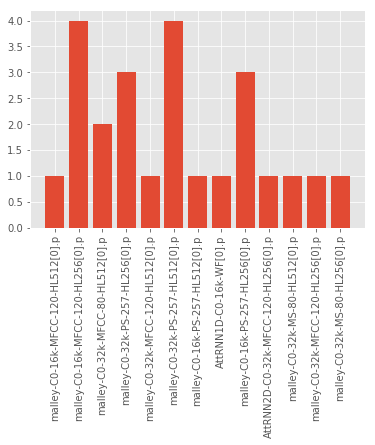

In [148]:
plt.bar([labels[f] for f in list(my_count.keys())],my_count.values())
plt.xticks(rotation = 90)

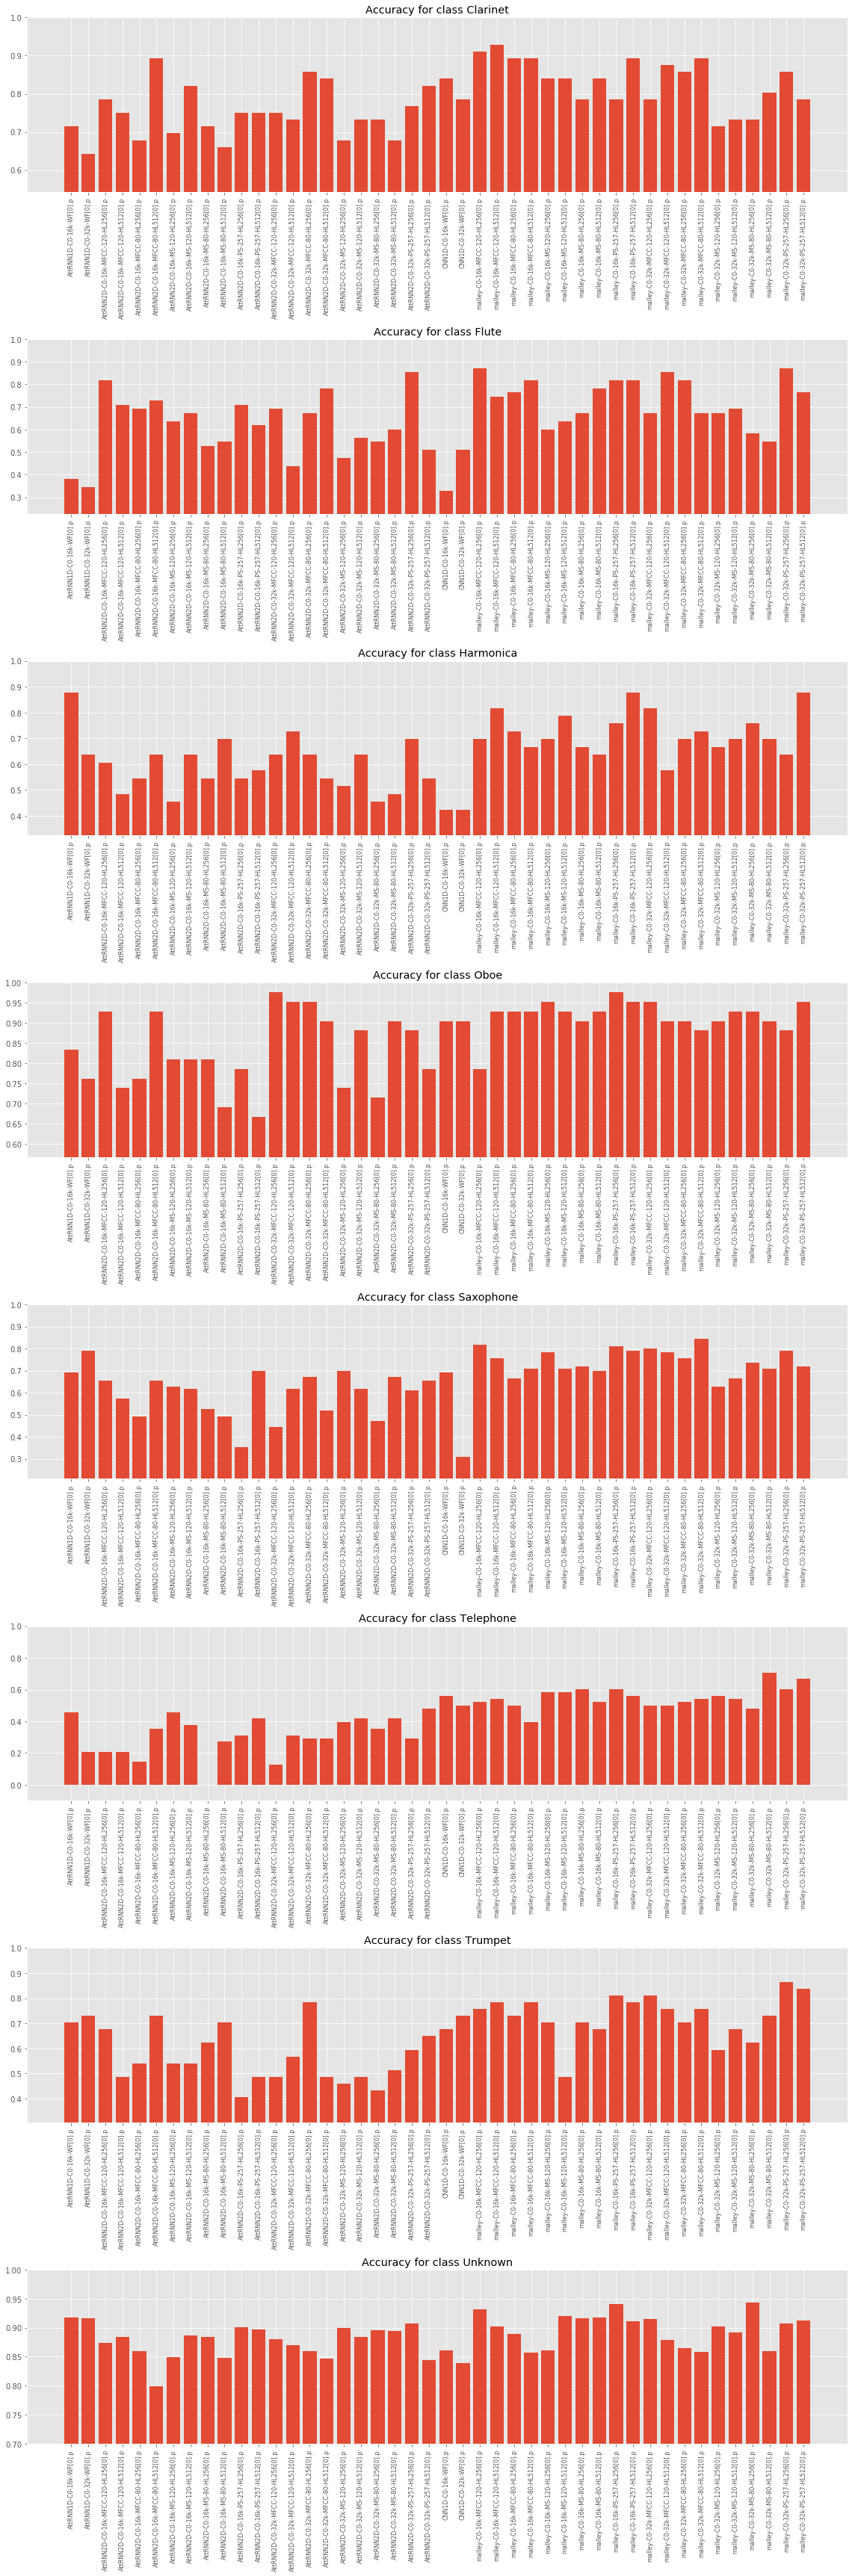

In [73]:
fig, axs = plt.subplots(len(this_mc),1,figsize = (16,48))

for i,ax in enumerate(axs):
    this_min = np.min(this_mc[i])
    this_rects = ax.bar(np.arange(44),this_mc[i])
    ax.set(ylim=[this_min-0.1,1])
    ax.set_title("Accuracy for class {}".format(c0_classes[i]))
    ticks = ax.set_xticks(np.arange(44))
    lab = ax.set_xticklabels(labels,rotation = 90,fontsize = 8)
plt.tight_layout()

### Cluster 1

In [74]:
this_mc = []
for i in range(len(mc1_perclass[0][1])):
    this_mc.append([d[i] for _,d in mc1_perclass])

In [75]:
mc_top_3 = []

for mc_class in this_mc:
    mc_top_3.append(sorted(zip(mc_class, np.arange(len(mc_class))), reverse=True)[:3])

In [76]:
for i,(a,b,c) in enumerate(mc_top_3):
    
    print('{}:'.format(c1_classes[i]))
    print('\tNumber 1: {} {:0.4f}'.format(labels[a[1]],a[0]))
    print('\tNumber 2: {} {:0.4f}'.format(labels[b[1]],b[0]))
    print('\tNumber 3: {} {:0.4f}'.format(labels[c[1]],c[0]))

Cello:
	Number 1: malley-C0-16k-PS-257-HL512[0].p 0.9259
	Number 2: malley-C0-16k-PS-257-HL256[0].p 0.9259
	Number 3: malley-C0-32k-MS-80-HL512[0].p 0.8889
Double Bass:
	Number 1: malley-C0-16k-PS-257-HL256[0].p 0.9750
	Number 2: malley-C0-32k-PS-257-HL256[0].p 0.9250
	Number 3: malley-C0-16k-PS-257-HL512[0].p 0.9250
Violin:
	Number 1: malley-C0-16k-MS-80-HL512[0].p 0.9722
	Number 2: malley-C0-32k-PS-257-HL256[0].p 0.9352
	Number 3: malley-C0-32k-MFCC-120-HL512[0].p 0.9352
Unknown:
	Number 1: malley-C0-32k-PS-257-HL256[0].p 0.9651
	Number 2: malley-C0-32k-PS-257-HL512[0].p 0.9508
	Number 3: malley-C0-16k-MS-120-HL512[0].p 0.9486


In [77]:
labels = [name for name,_ in mc1_perclass]

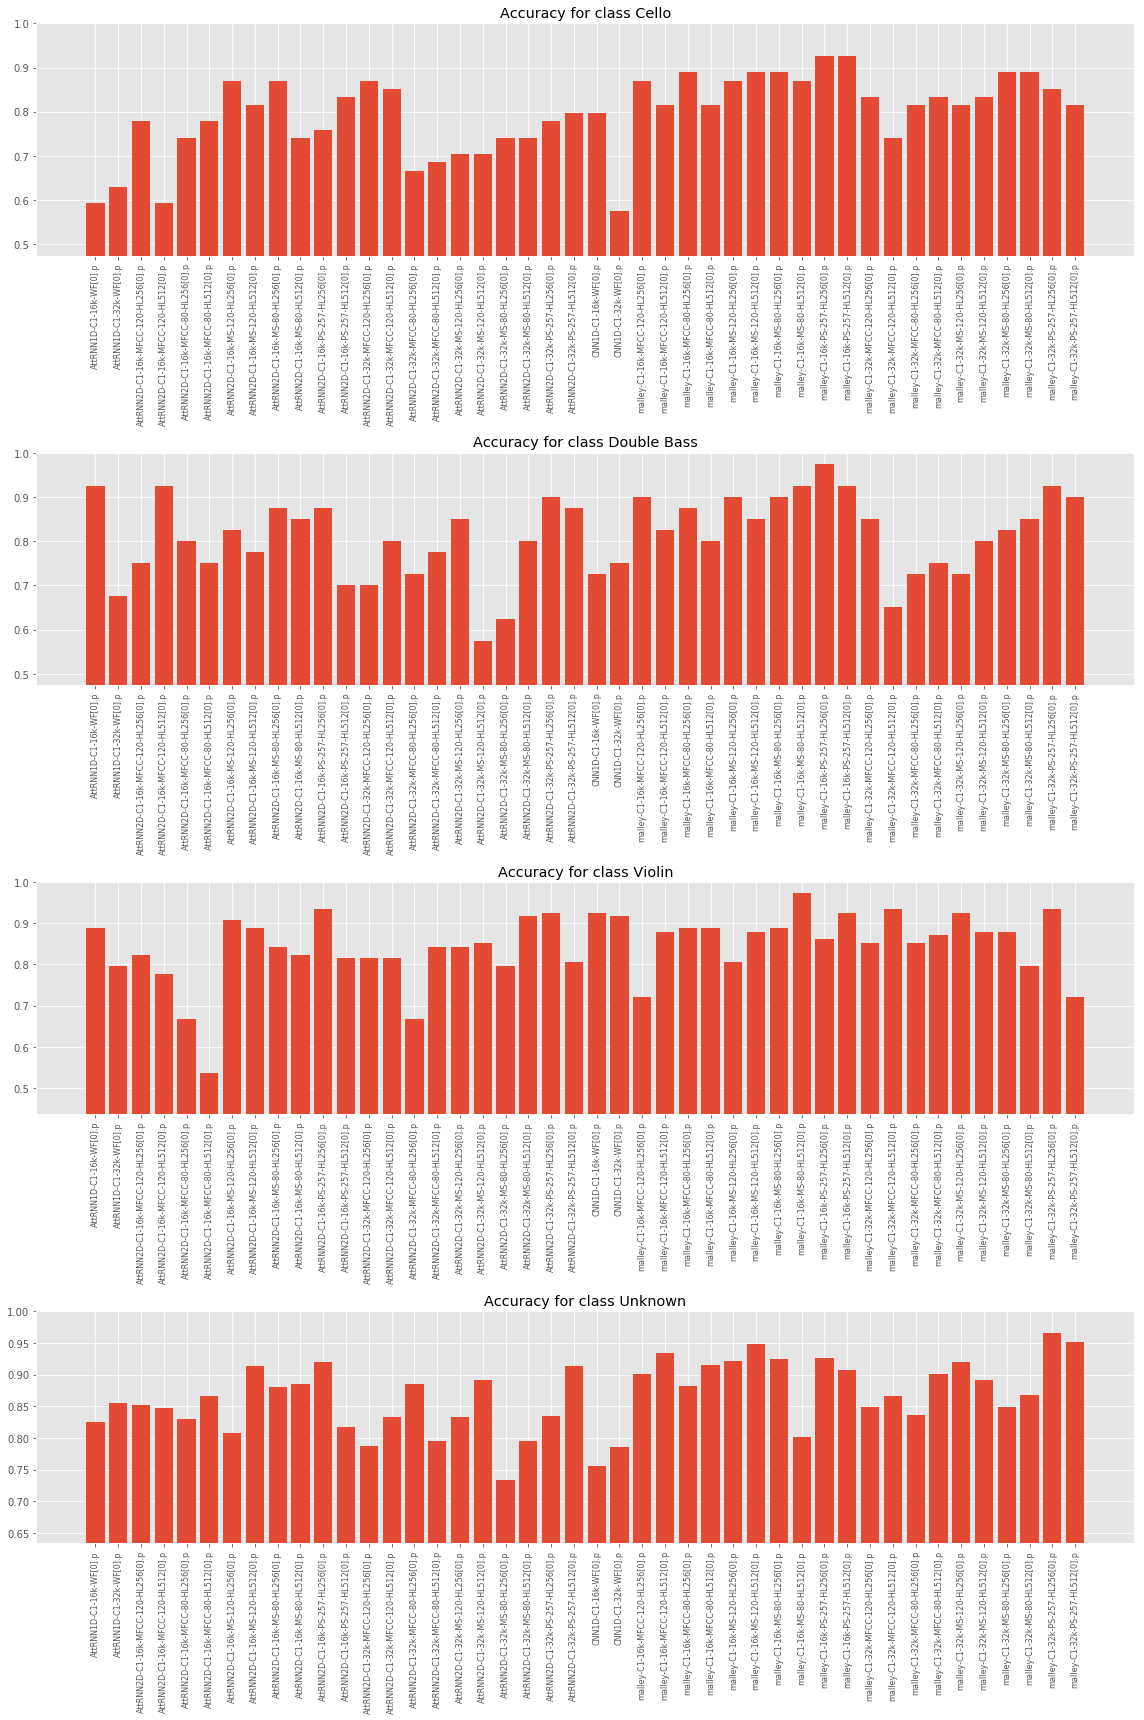

In [78]:
fig, axs = plt.subplots(len(this_mc),1,figsize = (16,24))

for i,ax in enumerate(axs):
    this_rects = ax.bar(np.arange(44),this_mc[i])
    this_min = np.min(this_mc[i])
    ax.set(ylim=[this_min-0.1,1])
    ax.set_title("Accuracy for class {}".format(c1_classes[i]))
    ticks = ax.set_xticks(np.arange(44))
    lab = ax.set_xticklabels(labels,rotation = 90,fontsize = 8)
plt.tight_layout()

### Cluster 2

In [79]:
this_mc = []
for i in range(len(mc2_perclass[0][1])):
    this_mc.append([d[i] for _,d in mc2_perclass])

In [80]:
mc_top_3 = []

for mc_class in this_mc:
    mc_top_3.append(sorted(zip(mc_class, np.arange(len(mc_class))), reverse=True)[:3])

In [82]:
for i,(a,b,c) in enumerate(mc_top_3):
    
    print('{}:'.format(c2_classes[i]))
    print('\tNumber 1: {} {:0.4f}'.format(labels[a[1]],a[0]))
    print('\tNumber 2: {} {:0.4f}'.format(labels[b[1]],b[0]))
    print('\tNumber 3: {} {:0.4f}'.format(labels[c[1]],c[0]))

Bass Drum:
	Number 1: malley-C1-32k-PS-257-HL512[0].p 1.0000
	Number 2: malley-C1-32k-PS-257-HL256[0].p 1.0000
	Number 3: malley-C1-32k-MS-80-HL256[0].p 1.0000
Burping:
	Number 1: malley-C1-32k-MS-80-HL512[0].p 1.0000
	Number 2: malley-C1-32k-MS-80-HL256[0].p 1.0000
	Number 3: malley-C1-16k-PS-257-HL512[0].p 1.0000
Computer Keyboard:
	Number 1: malley-C1-32k-PS-257-HL256[0].p 0.8846
	Number 2: malley-C1-32k-MS-80-HL256[0].p 0.8077
	Number 3: malley-C1-16k-PS-257-HL256[0].p 0.8077
Cowbell:
	Number 1: malley-C1-16k-MS-80-HL512[0].p 0.9762
	Number 2: malley-C1-16k-MFCC-120-HL512[0].p 0.9762
	Number 3: CNN1D-C1-16k-WF[0].p 0.9762
Drawer:
	Number 1: malley-C1-16k-PS-257-HL512[0].p 0.7931
	Number 2: malley-C1-16k-MS-120-HL256[0].p 0.7931
	Number 3: malley-C1-16k-MFCC-80-HL512[0].p 0.7931
Fart:
	Number 1: malley-C1-16k-PS-257-HL512[0].p 0.9000
	Number 2: malley-C1-16k-PS-257-HL256[0].p 0.9000
	Number 3: malley-C1-16k-MS-80-HL256[0].p 0.9000
Finger Snapping:
	Number 1: AttRNN2D-C1-32k-MS-80-HL

In [83]:
labels = [name for name,_ in mc2_perclass]

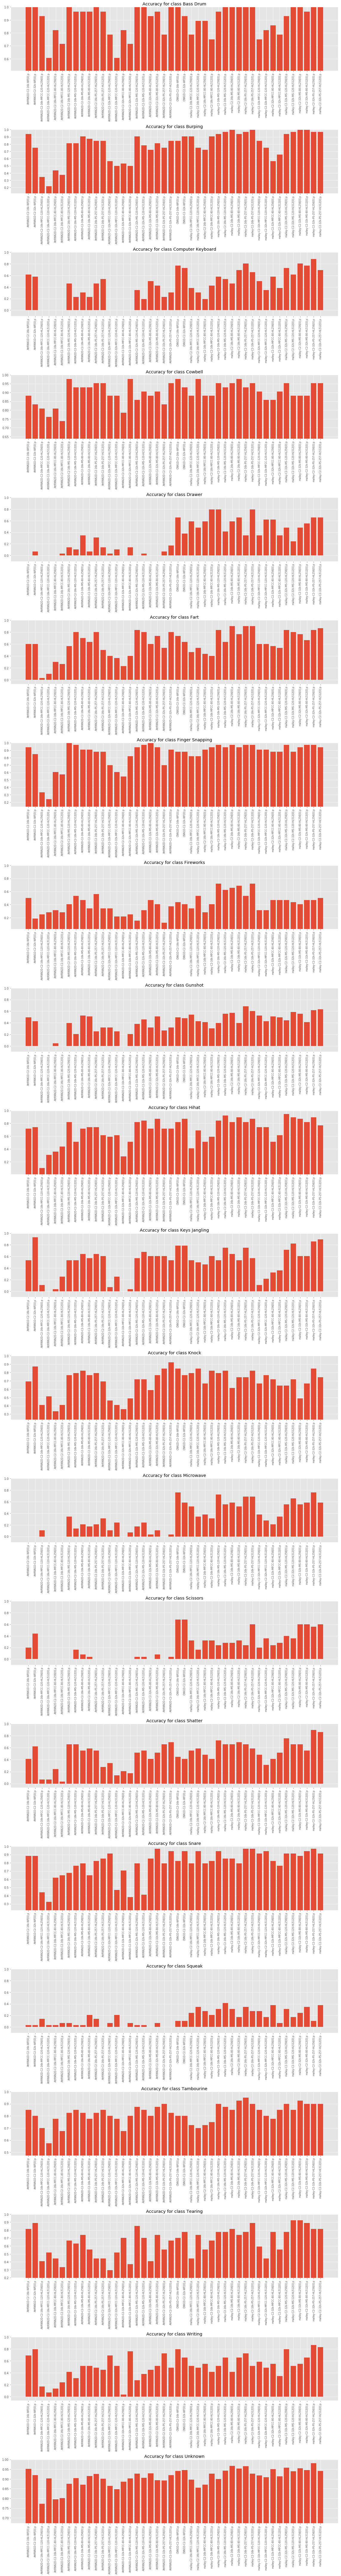

In [84]:
fig, axs = plt.subplots(len(this_mc),1,figsize = (16,120))

for i,ax in enumerate(axs):
    this_rects = ax.bar(np.arange(44),this_mc[i])
    this_min = np.min(this_mc[i])
    ax.set(ylim=[this_min-0.1,1])
    ax.set_title("Accuracy for class {}".format(c2_classes[i]))
    ticks = ax.set_xticks(np.arange(44))
    lab = ax.set_xticklabels(labels,rotation = 90,fontsize = 8)
plt.tight_layout()

### Cluster 3

In [85]:
this_mc = []
for i in range(len(mc3_perclass[0][1])):
    this_mc.append([d[i] for _,d in mc3_perclass])

In [86]:
mc_top_3 = []

for mc_class in this_mc:
    mc_top_3.append(sorted(zip(mc_class, np.arange(len(mc_class))), reverse=True)[:3])

In [87]:
for i,(a,b,c) in enumerate(mc_top_3):
    
    print('{}:'.format(c3_classes[i]))
    print('\tNumber 1: {} {:0.4f}'.format(labels[a[1]],a[0]))
    print('\tNumber 2: {} {:0.4f}'.format(labels[b[1]],b[0]))
    print('\tNumber 3: {} {:0.4f}'.format(labels[c[1]],c[0]))

Acoustic Guitar:
	Number 1: malley-C2-16k-PS-257-HL256[0].p 0.9333
	Number 2: malley-C2-32k-PS-257-HL512[0].p 0.8444
	Number 3: malley-C2-16k-MS-80-HL256[0].p 0.8444
Bus:
	Number 1: malley-C2-32k-MS-80-HL512[0].p 0.8400
	Number 2: malley-C2-16k-MS-120-HL512[0].p 0.8000
	Number 3: AttRNN2D-C2-16k-PS-257-HL512[0].p 0.8000
Chime:
	Number 1: malley-C2-32k-PS-257-HL512[0].p 0.8276
	Number 2: malley-C2-16k-PS-257-HL256[0].p 0.8276
	Number 3: malley-C2-16k-MS-120-HL256[0].p 0.8276
Electric Piano:
	Number 1: malley-C2-16k-MFCC-120-HL512[0].p 0.8125
	Number 2: malley-C2-32k-PS-257-HL256[0].p 0.7812
	Number 3: malley-C2-32k-MFCC-120-HL512[0].p 0.7500
Glockenspiel:
	Number 1: malley-C2-16k-PS-257-HL512[0].p 0.8276
	Number 2: malley-C2-32k-PS-257-HL256[0].p 0.7931
	Number 3: malley-C2-16k-MS-120-HL256[0].p 0.7241
Gong:
	Number 1: malley-C2-16k-PS-257-HL512[0].p 0.9459
	Number 2: malley-C2-16k-PS-257-HL256[0].p 0.9459
	Number 3: malley-C2-16k-MS-80-HL512[0].p 0.9189
Unknown:
	Number 1: malley-C2-16

In [88]:
labels = [name for name,_ in mc3_perclass]

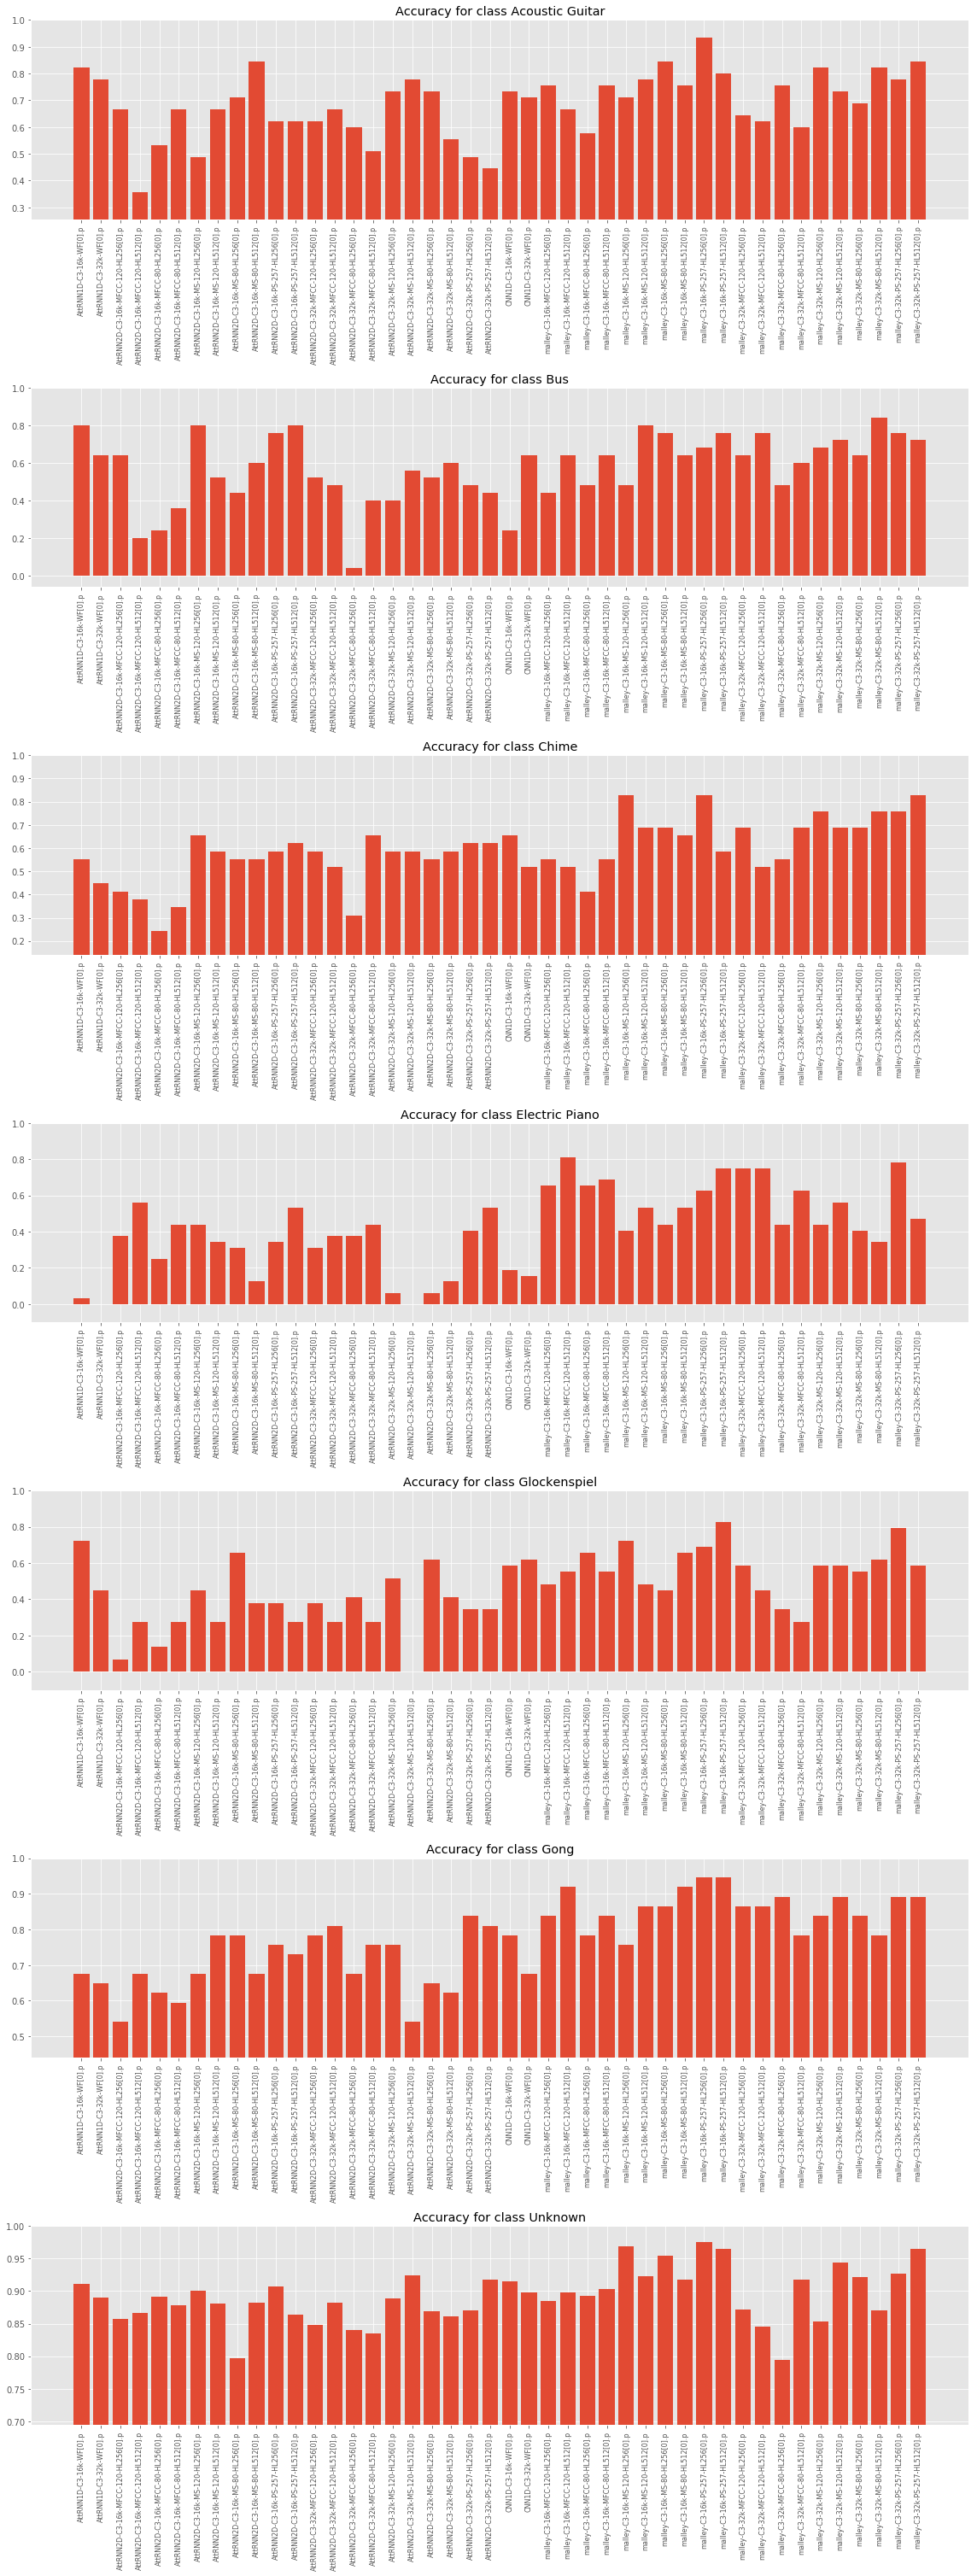

In [89]:
fig, axs = plt.subplots(len(this_mc),1,figsize = (16,42))

for i,ax in enumerate(axs):
    this_rects = ax.bar(np.arange(44),this_mc[i])
    this_min = np.min(this_mc[i])
    ax.set(ylim=[this_min-0.1,1])
    ax.set_title("Accuracy for class {}".format(c3_classes[i]))
    ticks = ax.set_xticks(np.arange(44))
    lab = ax.set_xticklabels(labels,rotation = 90,fontsize = 8)
plt.tight_layout()

### Cluster 5

In [90]:
this_mc = []
for i in range(len(mc5_perclass[0][1])):
    this_mc.append([d[i] for _,d in mc5_perclass])

In [91]:
mc_top_3 = []

for mc_class in this_mc:
    mc_top_3.append(sorted(zip(mc_class, np.arange(len(mc_class))), reverse=True)[:3])

In [92]:
for i,(a,b,c) in enumerate(mc_top_3):
    
    print('{}:'.format(c5_classes[i]))
    print('\tNumber 1: {} {:0.4f}'.format(labels[a[1]],a[0]))
    print('\tNumber 2: {} {:0.4f}'.format(labels[b[1]],b[0]))
    print('\tNumber 3: {} {:0.4f}'.format(labels[c[1]],c[0]))

Bark:
	Number 1: AttRNN2D-C3-16k-PS-257-HL512[0].p 0.9643
	Number 2: AttRNN2D-C3-16k-MS-120-HL512[0].p 0.9643
	Number 3: malley-C3-32k-PS-257-HL256[0].p 0.9286
Cough:
	Number 1: malley-C3-32k-PS-257-HL512[0].p 0.9667
	Number 2: malley-C3-16k-PS-257-HL512[0].p 0.9667
	Number 3: malley-C3-16k-MS-120-HL512[0].p 0.9667
Laughter:
	Number 1: malley-C3-16k-PS-257-HL256[0].p 0.9474
	Number 2: malley-C3-16k-MS-120-HL256[0].p 0.9474
	Number 3: malley-C3-32k-PS-257-HL256[0].p 0.8947
Meow:
	Number 1: malley-C3-16k-PS-257-HL256[0].p 1.0000
	Number 2: malley-C3-32k-PS-257-HL512[0].p 0.9655
	Number 3: malley-C3-32k-MS-120-HL512[0].p 0.9655
Unknown:
	Number 1: malley-C3-16k-PS-257-HL256[0].p 0.9914
	Number 2: malley-C3-16k-MS-120-HL256[0].p 0.9912
	Number 3: malley-C3-16k-MS-120-HL512[0].p 0.9750


In [93]:
labels = [name for name,_ in mc5_perclass]

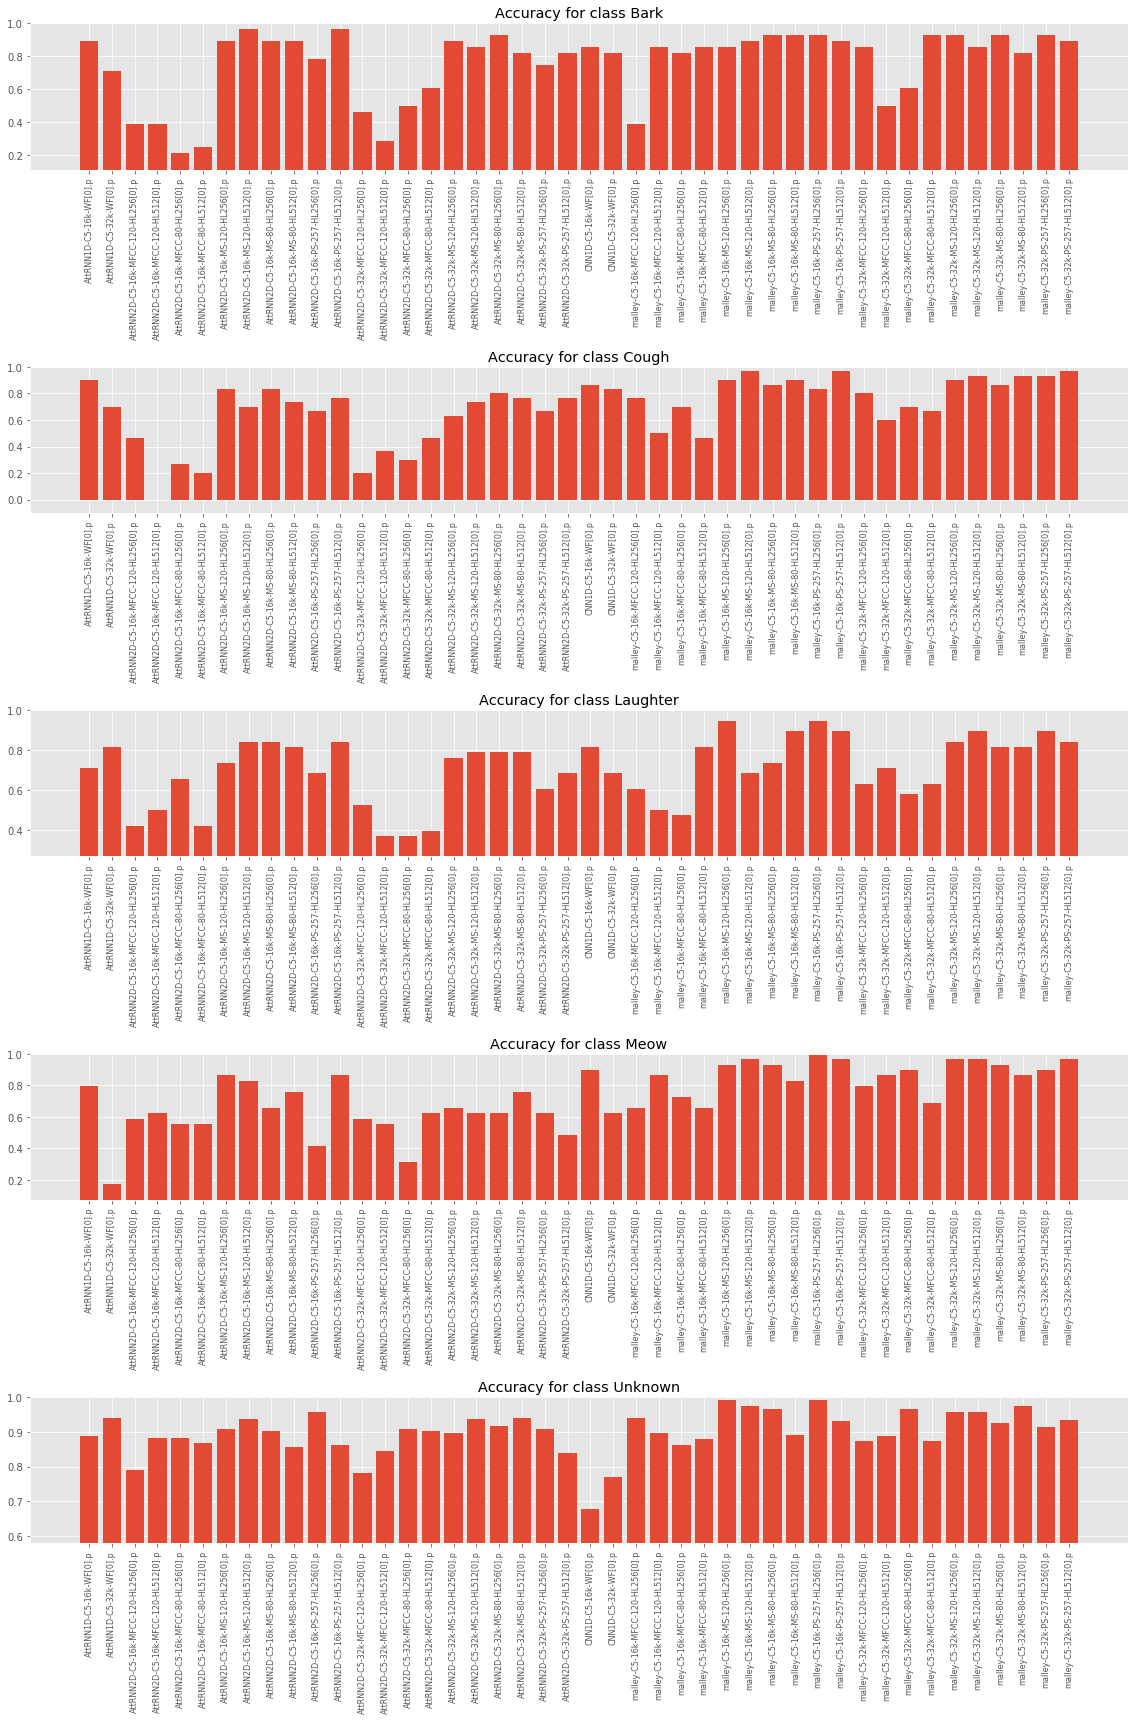

In [94]:
fig, axs = plt.subplots(len(this_mc),1,figsize = (16,24))

for i,ax in enumerate(axs):
    this_rects = ax.bar(np.arange(44),this_mc[i])
    this_min = np.min(this_mc[i])
    ax.set(ylim=[this_min-0.1,1])
    ax.set_title("Accuracy for class {}".format(c5_classes[i]))
    ticks = ax.set_xticks(np.arange(44))
    lab = ax.set_xticklabels(labels,rotation = 90,fontsize = 8)
plt.tight_layout()

In [9]:
i = np.random.randint(0,len(data))

print(i)
print(data[i]['test_acc'],data[i]['map3'])

192
0.6920980929678727 0.8029064486830155


In [25]:
test_accs = []
test_map3s = []
mc = []
for this_dict in data:
    test_accs.append(this_dict['test_acc'])
    test_map3s.append(this_dict['map3'])
    mc.append(this_dict['cluster'])

In [26]:
#with open('./map3list.p', 'wb') as fp:
    #pickle.dump(test_map3s,fp)

In [27]:
test_acc_df = pd.DataFrame(data = [[i,j,k,l] for i,j,k,l in zip(pickle_logs_names,test_accs,test_map3s,mc)],columns = ['Experiment','Test Accuracy','Map3','Meta Class'])


In [28]:
test_acc_mc0 = test_acc_df[test_acc_df['Meta Class'] == 0]
test_acc_mc1 = test_acc_df[test_acc_df['Meta Class'] == 1]
test_acc_mc2 = test_acc_df[test_acc_df['Meta Class'] == 2]
test_acc_mc3 = test_acc_df[test_acc_df['Meta Class'] == 3]
test_acc_mc4 = test_acc_df[test_acc_df['Meta Class'] == 4]
test_acc_mc5 = test_acc_df[test_acc_df['Meta Class'] == 5]

In [58]:
test_acc_mc0['Network'] = [f.split('-')[0] for f in test_acc_mc0['Experiment']]
test_acc_mc0['SR'] = [f.split('-')[2] for f in test_acc_mc0['Experiment']]
test_acc_mc0['Representation'] = [f.split('-')[3] for f in test_acc_mc0['Experiment']]

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [59]:
AttRNN1D_df = test_acc_mc0[test_acc_mc0['Network']=='AttRNN1D']

AttRNN2D_df = test_acc_mc0[test_acc_mc0['Network']=='AttRNN2D']

AttRNN2D_MFCC_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MFCC']
AttRNN2D_MFCC_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Frames'] = AttRNN2D_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_MS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MS']
AttRNN2D_MS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Frames'] = AttRNN2D_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_PS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='PS']
AttRNN2D_PS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Frames'] = AttRNN2D_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

CNN1D_df = test_acc_mc0[test_acc_mc0['Network']=='CNN1D']

malley_df = test_acc_mc0[test_acc_mc0['Network']=='malley']

malley_MFCC_df = malley_df[malley_df['Representation']=='MFCC']
malley_MFCC_df['Freq Res'] = [f.split('-')[4] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Time Res'] = [f.split('-')[5] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Frames'] = malley_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_MS_df = malley_df[malley_df['Representation']=='MS']
malley_MS_df['Freq Res'] = [f.split('-')[4] for f in malley_MS_df['Experiment']]
malley_MS_df['Time Res'] = [f.split('-')[5] for f in malley_MS_df['Experiment']]
malley_MS_df['Frames'] = malley_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_PS_df = malley_df[malley_df['Representation']=='PS']
malley_PS_df['Freq Res'] = [f.split('-')[4] for f in malley_PS_df['Experiment']]
malley_PS_df['Time Res'] = [f.split('-')[5] for f in malley_PS_df['Experiment']]
malley_PS_df['Frames'] = malley_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [60]:
AttRNN2D_MFCC_df

,Experiment,Test Accuracy,Map3,Meta Class,Network,SR,Representation,Freq Res,Time Res,Frames
10,AttRNN2D-C0-16k-MFCC-120-HL256-[0].p,0.756757,0.835586,0,AttRNN2D,16k,MFCC,120,HL256,250
11,AttRNN2D-C0-16k-MFCC-120-HL512-[0].p,0.708767,0.793710,0,AttRNN2D,16k,MFCC,120,HL512,125
12,AttRNN2D-C0-16k-MFCC-80-HL256-[0].p,0.682819,0.769701,0,AttRNN2D,16k,MFCC,80,HL256,250
13,AttRNN2D-C0-16k-MFCC-80-HL512-[0].p,0.741353,0.822306,0,AttRNN2D,16k,MFCC,80,HL512,125
20,AttRNN2D-C0-32k-MFCC-120-HL256-[0].p,0.698795,0.790412,0,AttRNN2D,32k,MFCC,120,HL256,250
21,AttRNN2D-C0-32k-MFCC-120-HL512-[0].p,0.721805,0.804261,0,AttRNN2D,32k,MFCC,120,HL512,125
22,AttRNN2D-C0-32k-MFCC-80-HL256-[0].p,0.762406,0.833584,0,AttRNN2D,32k,MFCC,80,HL256,250
23,AttRNN2D-C0-32k-MFCC-80-HL512-[0].p,0.714502,0.795821,0,AttRNN2D,32k,MFCC,80,HL512,125


In [61]:
labels1 = ['{}'.format(f) for f in AttRNN1D_df['SR']]

labels2 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MFCC_df['SR'],AttRNN2D_MFCC_df['Freq Res'],AttRNN2D_MFCC_df['Frames'])]
labels3 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MS_df['SR'],AttRNN2D_MS_df['Freq Res'],AttRNN2D_MS_df['Frames'])]
labels4 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_PS_df['SR'],AttRNN2D_PS_df['Freq Res'],AttRNN2D_PS_df['Frames'])]

labels5 = ['{}'.format(f) for f in CNN1D_df['SR']]

labels6 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MFCC_df['SR'],malley_MFCC_df['Freq Res'],malley_MFCC_df['Frames'])]
labels7 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MS_df['SR'],malley_MS_df['Freq Res'],malley_MS_df['Frames'])]
labels8 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_PS_df['SR'],malley_PS_df['Freq Res'],malley_PS_df['Frames'])]

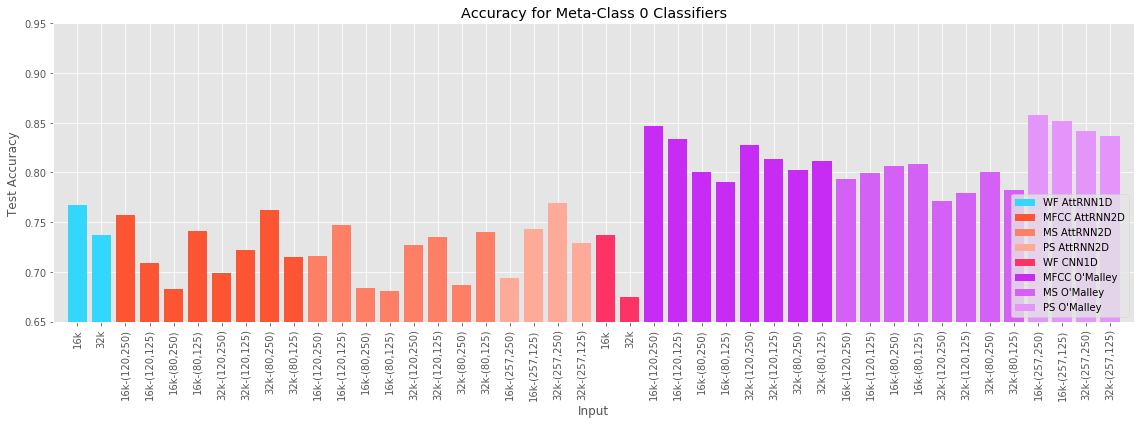

In [62]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Test Accuracy'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Test Accuracy'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Test Accuracy'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Test Accuracy'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Test Accuracy'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Test Accuracy'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Test Accuracy'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Test Accuracy'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.65,0.95],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('Accuracy for Meta-Class 0 Classifiers')
plt.tight_layout()
plt.savefig('./MC0_Accuracy.eps')

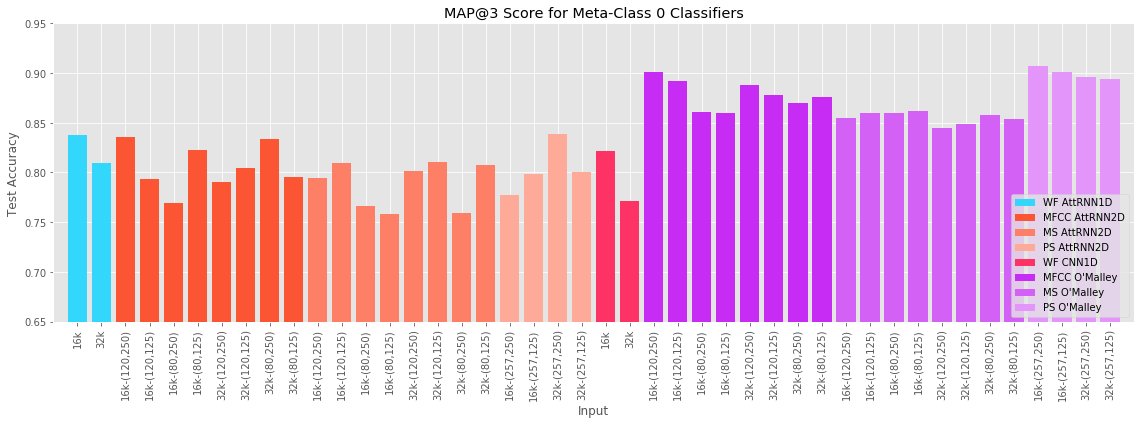

In [63]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Map3'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Map3'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Map3'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Map3'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Map3'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Map3'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Map3'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Map3'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.65,0.95],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('MAP@3 Score for Meta-Class 0 Classifiers')
plt.tight_layout()
plt.savefig('./MC0_Map3.eps')

### Meta Class 1

In [36]:
#test_acc_df = pd.DataFrame(data = [[i,j,k] for i,j,k in zip(pickle_logs_names,test_acc_allmc,mc)],columns = ['Experiment','Test Accuracy','Meta Class'])

#test_acc_mc0 = test_acc_df[test_acc_df['Meta Class'] == 0]
#test_acc_mc1 = test_acc_df[test_acc_df['Meta Class'] == 1]
#test_acc_mc2 = test_acc_df[test_acc_df['Meta Class'] == 2]
#test_acc_mc3 = test_acc_df[test_acc_df['Meta Class'] == 3]
#test_acc_mc4 = test_acc_df[test_acc_df['Meta Class'] == 4]
#test_acc_mc5 = test_acc_df[test_acc_df['Meta Class'] == 5]

test_acc_mc1['Network'] = [f.split('-')[0] for f in test_acc_mc1['Experiment']]
test_acc_mc1['SR'] = [f.split('-')[2] for f in test_acc_mc1['Experiment']]
test_acc_mc1['Representation'] = [f.split('-')[3] for f in test_acc_mc1['Experiment']]

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [37]:
AttRNN1D_df = test_acc_mc1[test_acc_mc1['Network']=='AttRNN1D']

AttRNN2D_df = test_acc_mc1[test_acc_mc1['Network']=='AttRNN2D']

AttRNN2D_MFCC_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MFCC']
AttRNN2D_MFCC_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Frames'] = AttRNN2D_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_MS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MS']
AttRNN2D_MS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Frames'] = AttRNN2D_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_PS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='PS']
AttRNN2D_PS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Frames'] = AttRNN2D_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

CNN1D_df = test_acc_mc1[test_acc_mc1['Network']=='CNN1D']

malley_df = test_acc_mc1[test_acc_mc1['Network']=='malley']

malley_MFCC_df = malley_df[malley_df['Representation']=='MFCC']
malley_MFCC_df['Freq Res'] = [f.split('-')[4] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Time Res'] = [f.split('-')[5] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Frames'] = malley_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_MS_df = malley_df[malley_df['Representation']=='MS']
malley_MS_df['Freq Res'] = [f.split('-')[4] for f in malley_MS_df['Experiment']]
malley_MS_df['Time Res'] = [f.split('-')[5] for f in malley_MS_df['Experiment']]
malley_MS_df['Frames'] = malley_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_PS_df = malley_df[malley_df['Representation']=='PS']
malley_PS_df['Freq Res'] = [f.split('-')[4] for f in malley_PS_df['Experiment']]
malley_PS_df['Time Res'] = [f.split('-')[5] for f in malley_PS_df['Experiment']]
malley_PS_df['Frames'] = malley_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [38]:
labels1 = ['{}'.format(f) for f in AttRNN1D_df['SR']]

labels2 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MFCC_df['SR'],AttRNN2D_MFCC_df['Freq Res'],AttRNN2D_MFCC_df['Frames'])]
labels3 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MS_df['SR'],AttRNN2D_MS_df['Freq Res'],AttRNN2D_MS_df['Frames'])]
labels4 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_PS_df['SR'],AttRNN2D_PS_df['Freq Res'],AttRNN2D_PS_df['Frames'])]

labels5 = ['{}'.format(f) for f in CNN1D_df['SR']]

labels6 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MFCC_df['SR'],malley_MFCC_df['Freq Res'],malley_MFCC_df['Frames'])]
labels7 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MS_df['SR'],malley_MS_df['Freq Res'],malley_MS_df['Frames'])]
labels8 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_PS_df['SR'],malley_PS_df['Freq Res'],malley_PS_df['Frames'])]

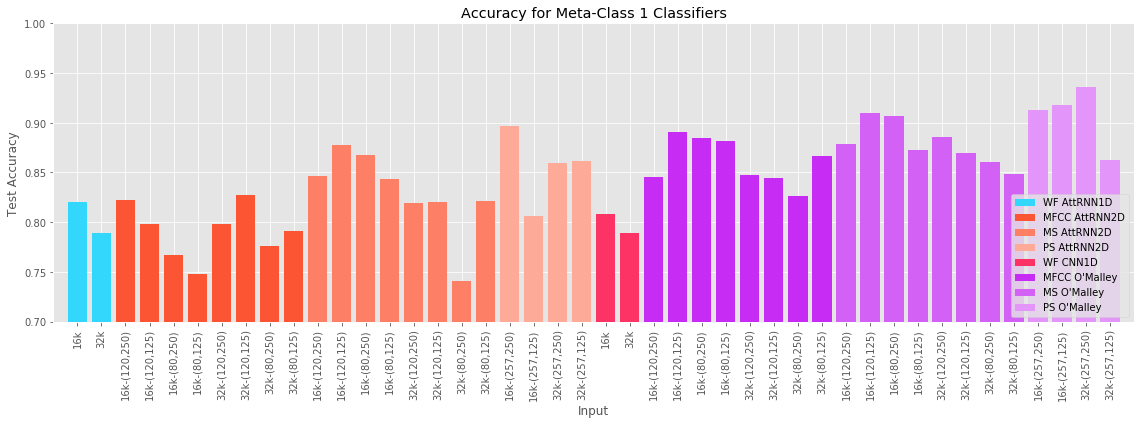

In [39]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Test Accuracy'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Test Accuracy'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Test Accuracy'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Test Accuracy'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Test Accuracy'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Test Accuracy'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Test Accuracy'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Test Accuracy'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.7,1],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('Accuracy for Meta-Class 1 Classifiers')
plt.tight_layout()
plt.savefig('./MC1_Accuracy.eps')

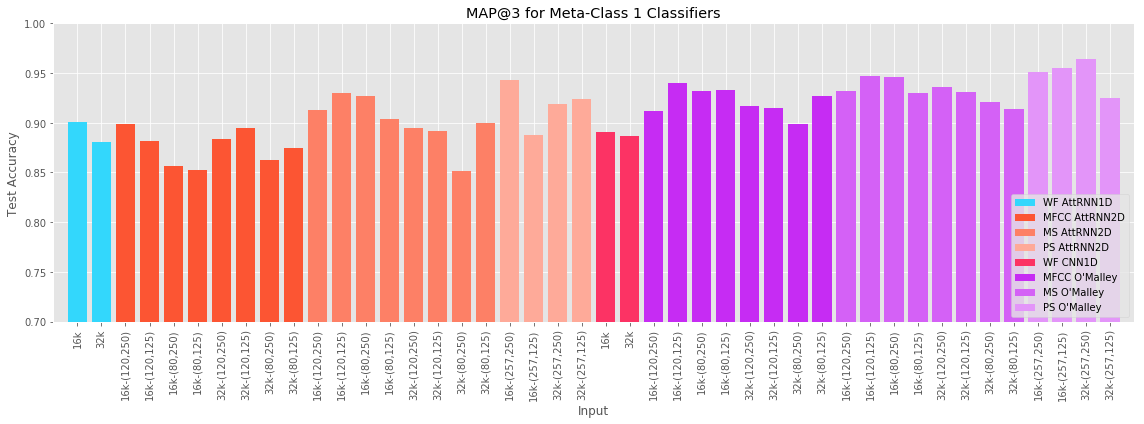

In [40]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Map3'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Map3'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Map3'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Map3'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Map3'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Map3'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Map3'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Map3'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.7,1],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('MAP@3 for Meta-Class 1 Classifiers')
plt.tight_layout()
plt.savefig('./MC1_Map3.eps')

### Meta Class 2

In [41]:
#test_acc_df = pd.DataFrame(data = [[i,j,k] for i,j,k in zip(pickle_logs_names,test_acc_allmc,mc)],columns = ['Experiment','Test Accuracy','Meta Class'])

#test_acc_mc0 = test_acc_df[test_acc_df['Meta Class'] == 0]
#test_acc_mc1 = test_acc_df[test_acc_df['Meta Class'] == 1]
#test_acc_mc2 = test_acc_df[test_acc_df['Meta Class'] == 2]
#test_acc_mc3 = test_acc_df[test_acc_df['Meta Class'] == 3]
#test_acc_mc4 = test_acc_df[test_acc_df['Meta Class'] == 4]
#test_acc_mc5 = test_acc_df[test_acc_df['Meta Class'] == 5]

test_acc_mc2['Network'] = [f.split('-')[0] for f in test_acc_mc2['Experiment']]
test_acc_mc2['SR'] = [f.split('-')[2] for f in test_acc_mc2['Experiment']]
test_acc_mc2['Representation'] = [f.split('-')[3] for f in test_acc_mc2['Experiment']]

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [42]:
AttRNN1D_df = test_acc_mc2[test_acc_mc2['Network']=='AttRNN1D']

AttRNN2D_df = test_acc_mc2[test_acc_mc2['Network']=='AttRNN2D']

AttRNN2D_MFCC_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MFCC']
AttRNN2D_MFCC_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Frames'] = AttRNN2D_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_MS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MS']
AttRNN2D_MS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Frames'] = AttRNN2D_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_PS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='PS']
AttRNN2D_PS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Frames'] = AttRNN2D_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

CNN1D_df = test_acc_mc2[test_acc_mc2['Network']=='CNN1D']

malley_df = test_acc_mc2[test_acc_mc2['Network']=='malley']

malley_MFCC_df = malley_df[malley_df['Representation']=='MFCC']
malley_MFCC_df['Freq Res'] = [f.split('-')[4] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Time Res'] = [f.split('-')[5] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Frames'] = malley_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_MS_df = malley_df[malley_df['Representation']=='MS']
malley_MS_df['Freq Res'] = [f.split('-')[4] for f in malley_MS_df['Experiment']]
malley_MS_df['Time Res'] = [f.split('-')[5] for f in malley_MS_df['Experiment']]
malley_MS_df['Frames'] = malley_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_PS_df = malley_df[malley_df['Representation']=='PS']
malley_PS_df['Freq Res'] = [f.split('-')[4] for f in malley_PS_df['Experiment']]
malley_PS_df['Time Res'] = [f.split('-')[5] for f in malley_PS_df['Experiment']]
malley_PS_df['Frames'] = malley_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [43]:
labels1 = ['{}'.format(f) for f in AttRNN1D_df['SR']]

labels2 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MFCC_df['SR'],AttRNN2D_MFCC_df['Freq Res'],AttRNN2D_MFCC_df['Frames'])]
labels3 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MS_df['SR'],AttRNN2D_MS_df['Freq Res'],AttRNN2D_MS_df['Frames'])]
labels4 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_PS_df['SR'],AttRNN2D_PS_df['Freq Res'],AttRNN2D_PS_df['Frames'])]

labels5 = ['{}'.format(f) for f in CNN1D_df['SR']]

labels6 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MFCC_df['SR'],malley_MFCC_df['Freq Res'],malley_MFCC_df['Frames'])]
labels7 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MS_df['SR'],malley_MS_df['Freq Res'],malley_MS_df['Frames'])]
labels8 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_PS_df['SR'],malley_PS_df['Freq Res'],malley_PS_df['Frames'])]

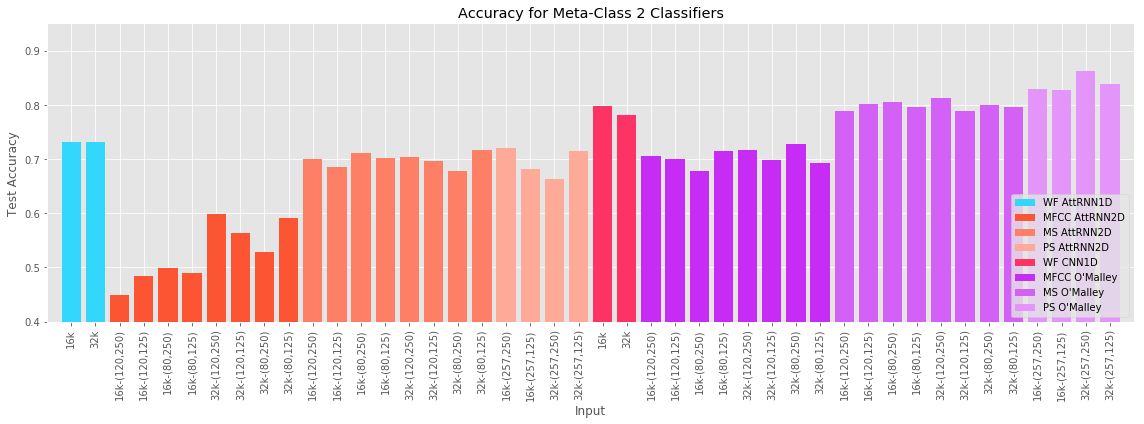

In [44]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Test Accuracy'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Test Accuracy'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Test Accuracy'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Test Accuracy'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Test Accuracy'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Test Accuracy'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Test Accuracy'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Test Accuracy'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.4,0.95],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('Accuracy for Meta-Class 2 Classifiers')
plt.tight_layout()
plt.savefig('./MC2_Accuracy.eps')

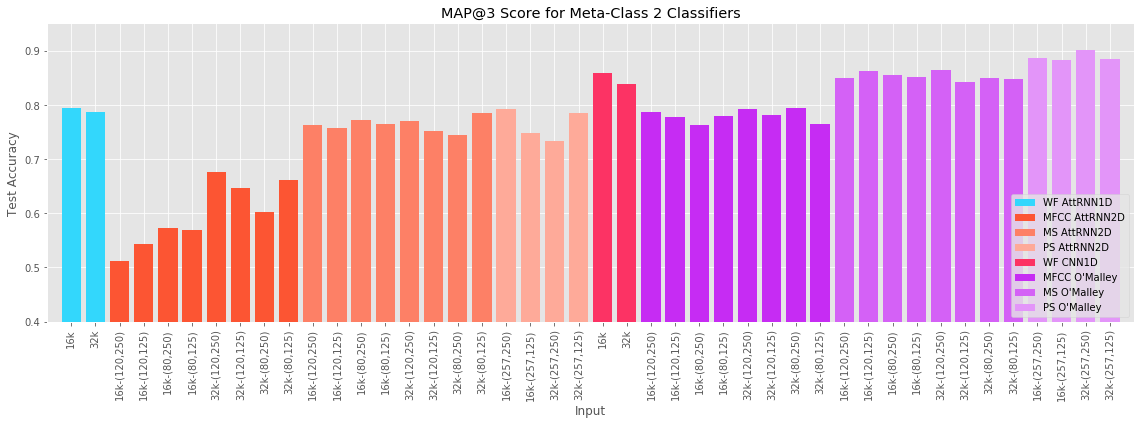

In [45]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Map3'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Map3'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Map3'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Map3'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Map3'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Map3'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Map3'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Map3'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.4,0.95],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('MAP@3 Score for Meta-Class 2 Classifiers')
plt.tight_layout()
plt.savefig('./MC2_MAP3.eps')

### Meta Class 3

In [46]:
#test_acc_df = pd.DataFrame(data = [[i,j,k] for i,j,k in zip(pickle_logs_names,test_acc_allmc,mc)],columns = ['Experiment','Test Accuracy','Meta Class'])

#test_acc_mc0 = test_acc_df[test_acc_df['Meta Class'] == 0]
#test_acc_mc1 = test_acc_df[test_acc_df['Meta Class'] == 1]
#test_acc_mc2 = test_acc_df[test_acc_df['Meta Class'] == 2]
#test_acc_mc3 = test_acc_df[test_acc_df['Meta Class'] == 3]
#test_acc_mc4 = test_acc_df[test_acc_df['Meta Class'] == 4]
#test_acc_mc5 = test_acc_df[test_acc_df['Meta Class'] == 5]

test_acc_mc3['Network'] = [f.split('-')[0] for f in test_acc_mc3['Experiment']]
test_acc_mc3['SR'] = [f.split('-')[2] for f in test_acc_mc3['Experiment']]
test_acc_mc3['Representation'] = [f.split('-')[3] for f in test_acc_mc3['Experiment']]

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [47]:
AttRNN1D_df = test_acc_mc3[test_acc_mc3['Network']=='AttRNN1D']

AttRNN2D_df = test_acc_mc3[test_acc_mc3['Network']=='AttRNN2D']

AttRNN2D_MFCC_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MFCC']
AttRNN2D_MFCC_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Frames'] = AttRNN2D_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_MS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MS']
AttRNN2D_MS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Frames'] = AttRNN2D_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_PS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='PS']
AttRNN2D_PS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Frames'] = AttRNN2D_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

CNN1D_df = test_acc_mc3[test_acc_mc3['Network']=='CNN1D']

malley_df = test_acc_mc3[test_acc_mc3['Network']=='malley']

malley_MFCC_df = malley_df[malley_df['Representation']=='MFCC']
malley_MFCC_df['Freq Res'] = [f.split('-')[4] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Time Res'] = [f.split('-')[5] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Frames'] = malley_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_MS_df = malley_df[malley_df['Representation']=='MS']
malley_MS_df['Freq Res'] = [f.split('-')[4] for f in malley_MS_df['Experiment']]
malley_MS_df['Time Res'] = [f.split('-')[5] for f in malley_MS_df['Experiment']]
malley_MS_df['Frames'] = malley_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_PS_df = malley_df[malley_df['Representation']=='PS']
malley_PS_df['Freq Res'] = [f.split('-')[4] for f in malley_PS_df['Experiment']]
malley_PS_df['Time Res'] = [f.split('-')[5] for f in malley_PS_df['Experiment']]
malley_PS_df['Frames'] = malley_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [48]:
labels1 = ['{}'.format(f) for f in AttRNN1D_df['SR']]

labels2 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MFCC_df['SR'],AttRNN2D_MFCC_df['Freq Res'],AttRNN2D_MFCC_df['Frames'])]
labels3 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MS_df['SR'],AttRNN2D_MS_df['Freq Res'],AttRNN2D_MS_df['Frames'])]
labels4 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_PS_df['SR'],AttRNN2D_PS_df['Freq Res'],AttRNN2D_PS_df['Frames'])]

labels5 = ['{}'.format(f) for f in CNN1D_df['SR']]

labels6 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MFCC_df['SR'],malley_MFCC_df['Freq Res'],malley_MFCC_df['Frames'])]
labels7 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MS_df['SR'],malley_MS_df['Freq Res'],malley_MS_df['Frames'])]
labels8 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_PS_df['SR'],malley_PS_df['Freq Res'],malley_PS_df['Frames'])]

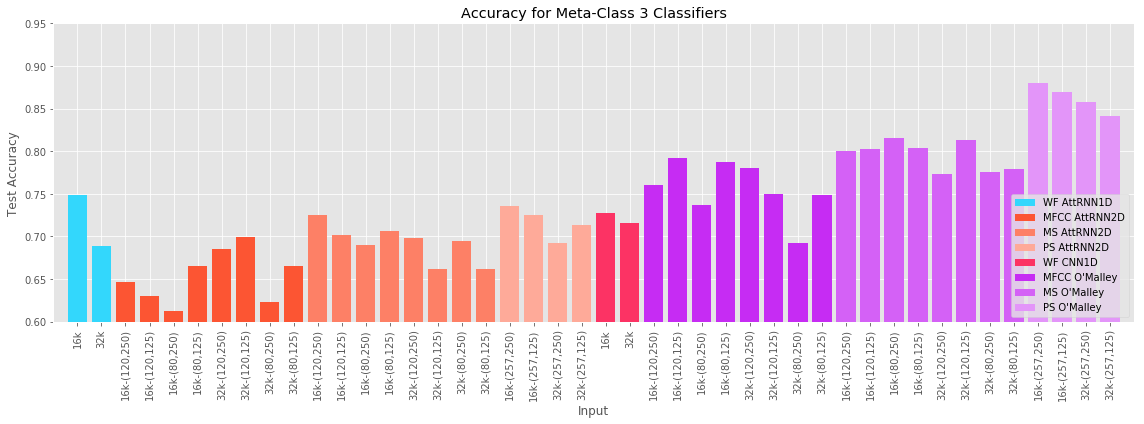

In [50]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Test Accuracy'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Test Accuracy'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Test Accuracy'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Test Accuracy'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Test Accuracy'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Test Accuracy'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Test Accuracy'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Test Accuracy'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.6,0.95],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('Accuracy for Meta-Class 3 Classifiers')
plt.tight_layout()
plt.savefig('./MC3_Accuracy.eps')

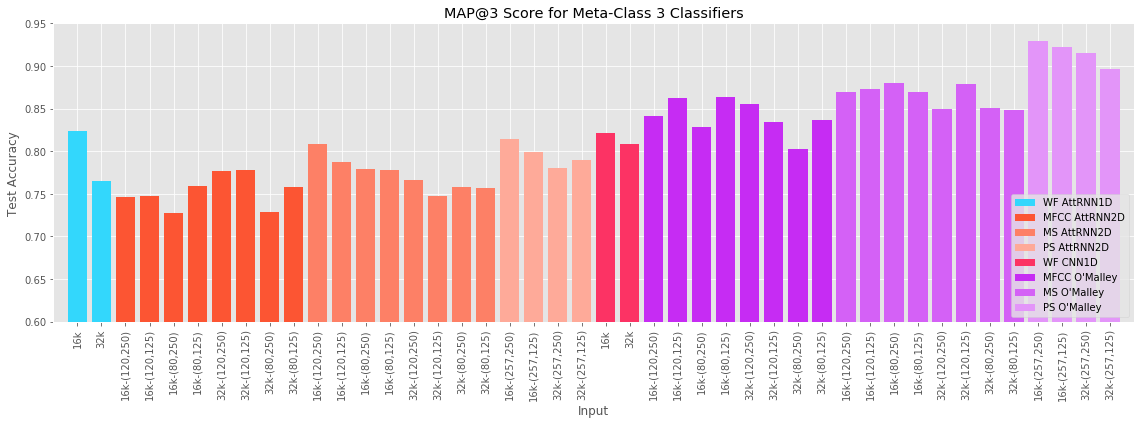

In [51]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Map3'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Map3'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Map3'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Map3'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Map3'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Map3'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Map3'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Map3'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.6,0.95],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('MAP@3 Score for Meta-Class 3 Classifiers')
plt.tight_layout()
plt.savefig('./MC3_MAP3.eps')

### Meta Class 5

In [52]:
#test_acc_df = pd.DataFrame(data = [[i,j,k] for i,j,k in zip(pickle_logs_names,test_acc_allmc,mc)],columns = ['Experiment','Test Accuracy','Meta Class'])

#test_acc_mc0 = test_acc_df[test_acc_df['Meta Class'] == 0]
#test_acc_mc1 = test_acc_df[test_acc_df['Meta Class'] == 1]
#test_acc_mc2 = test_acc_df[test_acc_df['Meta Class'] == 2]
#test_acc_mc3 = test_acc_df[test_acc_df['Meta Class'] == 3]
#test_acc_mc4 = test_acc_df[test_acc_df['Meta Class'] == 4]
#test_acc_mc5 = test_acc_df[test_acc_df['Meta Class'] == 5]

test_acc_mc5['Network'] = [f.split('-')[0] for f in test_acc_mc5['Experiment']]
test_acc_mc5['SR'] = [f.split('-')[2] for f in test_acc_mc5['Experiment']]
test_acc_mc5['Representation'] = [f.split('-')[3] for f in test_acc_mc5['Experiment']]

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [53]:
AttRNN1D_df = test_acc_mc5[test_acc_mc5['Network']=='AttRNN1D']

AttRNN2D_df = test_acc_mc5[test_acc_mc5['Network']=='AttRNN2D']

AttRNN2D_MFCC_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MFCC']
AttRNN2D_MFCC_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MFCC_df['Experiment']]
AttRNN2D_MFCC_df['Frames'] = AttRNN2D_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_MS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='MS']
AttRNN2D_MS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_MS_df['Experiment']]
AttRNN2D_MS_df['Frames'] = AttRNN2D_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

AttRNN2D_PS_df = AttRNN2D_df[AttRNN2D_df['Representation']=='PS']
AttRNN2D_PS_df['Freq Res'] = [f.split('-')[4] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Time Res'] = [f.split('-')[5] for f in AttRNN2D_PS_df['Experiment']]
AttRNN2D_PS_df['Frames'] = AttRNN2D_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

CNN1D_df = test_acc_mc5[test_acc_mc5['Network']=='CNN1D']

malley_df = test_acc_mc5[test_acc_mc5['Network']=='malley']

malley_MFCC_df = malley_df[malley_df['Representation']=='MFCC']
malley_MFCC_df['Freq Res'] = [f.split('-')[4] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Time Res'] = [f.split('-')[5] for f in malley_MFCC_df['Experiment']]
malley_MFCC_df['Frames'] = malley_MFCC_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_MS_df = malley_df[malley_df['Representation']=='MS']
malley_MS_df['Freq Res'] = [f.split('-')[4] for f in malley_MS_df['Experiment']]
malley_MS_df['Time Res'] = [f.split('-')[5] for f in malley_MS_df['Experiment']]
malley_MS_df['Frames'] = malley_MS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

malley_PS_df = malley_df[malley_df['Representation']=='PS']
malley_PS_df['Freq Res'] = [f.split('-')[4] for f in malley_PS_df['Experiment']]
malley_PS_df['Time Res'] = [f.split('-')[5] for f in malley_PS_df['Experiment']]
malley_PS_df['Frames'] = malley_PS_df['Time Res'].apply(lambda x: '125' if x == 'HL512' else '250')

/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/edoardobucheli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [54]:
labels1 = ['{}'.format(f) for f in AttRNN1D_df['SR']]

labels2 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MFCC_df['SR'],AttRNN2D_MFCC_df['Freq Res'],AttRNN2D_MFCC_df['Frames'])]
labels3 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_MS_df['SR'],AttRNN2D_MS_df['Freq Res'],AttRNN2D_MS_df['Frames'])]
labels4 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(AttRNN2D_PS_df['SR'],AttRNN2D_PS_df['Freq Res'],AttRNN2D_PS_df['Frames'])]

labels5 = ['{}'.format(f) for f in CNN1D_df['SR']]

labels6 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MFCC_df['SR'],malley_MFCC_df['Freq Res'],malley_MFCC_df['Frames'])]
labels7 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_MS_df['SR'],malley_MS_df['Freq Res'],malley_MS_df['Frames'])]
labels8 = ['{}-({},{})'.format(f,j,k) for f,j,k in zip(malley_PS_df['SR'],malley_PS_df['Freq Res'],malley_PS_df['Frames'])]

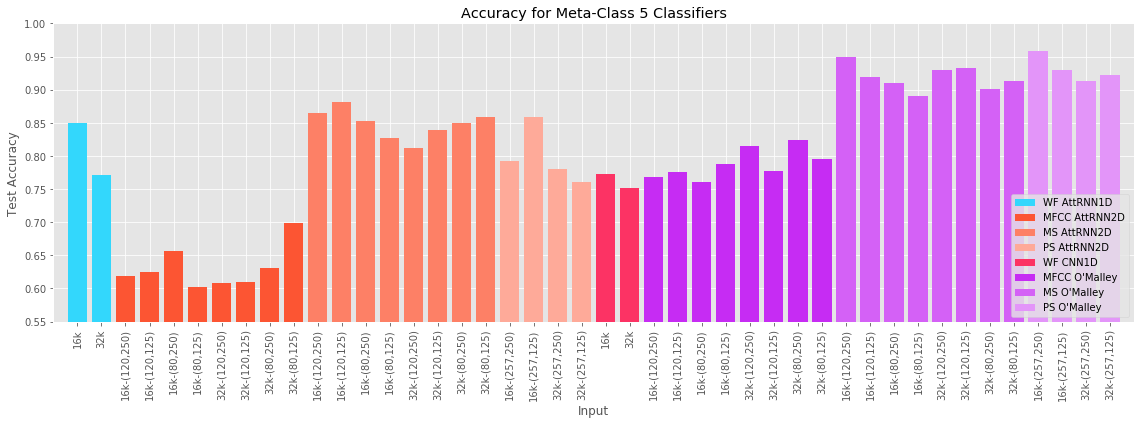

In [55]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Test Accuracy'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Test Accuracy'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Test Accuracy'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Test Accuracy'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Test Accuracy'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Test Accuracy'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Test Accuracy'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Test Accuracy'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.55,1],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('Accuracy for Meta-Class 5 Classifiers')
plt.tight_layout()
plt.savefig('./MC5_Accuracy.eps')

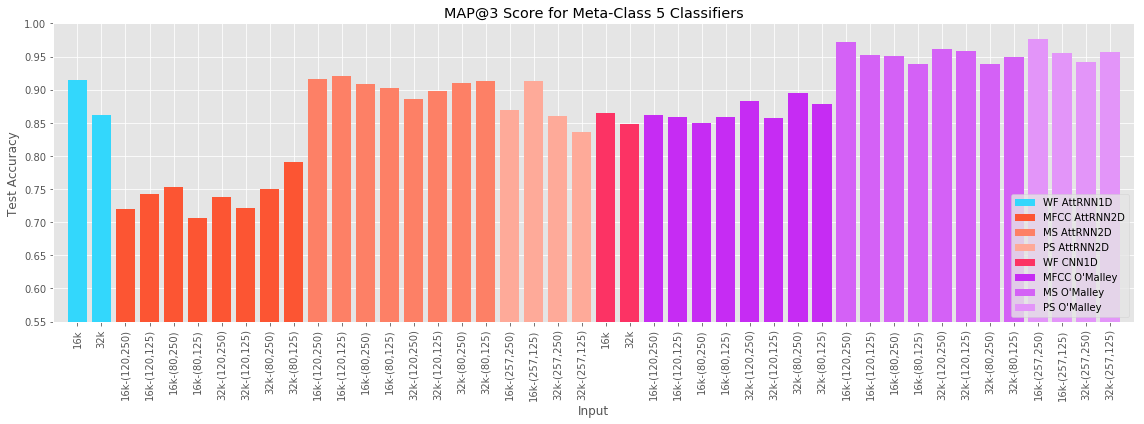

In [56]:
fig, ax = plt.subplots(1,1,figsize = (16,6))

rects1 = ax.bar(rects1_x,AttRNN1D_df['Map3'],label = 'WF AttRNN1D',color = '#33D7FC')

rects2 = ax.bar(rects2_x,AttRNN2D_MFCC_df['Map3'],label = 'MFCC AttRNN2D',color = '#FC5533')
rects3 = ax.bar(rects3_x,AttRNN2D_MS_df['Map3'],label = 'MS AttRNN2D',color = '#FD8066')
rects4 = ax.bar(rects4_x,AttRNN2D_PS_df['Map3'],label = 'PS AttRNN2D',color = '#FEAA99')

rects5 = ax.bar(rects5_x,CNN1D_df['Map3'],label = 'WF CNN1D',color = '#FC3364')

rects6 = ax.bar(rects6_x,malley_MFCC_df['Map3'],label = "MFCC O\'Malley",color = '#C62CF3')
rects7 = ax.bar(rects7_x,malley_MS_df['Map3'],label = "MS O\'Malley",color = '#D461F6')
rects8 = ax.bar(rects8_x,malley_PS_df['Map3'],label = "PS O\'Malley",color = '#E395F9')

ax.set(ylim = [0.55,1],xlim = [-1,44])

ax.legend(loc = 'lower right')

ax.set_xlabel('Input')
ax.set_ylabel('Test Accuracy')

fig = ax.set_xticks(x)
fig = ax.set_xticklabels(labels1+labels2+labels3+labels4+labels5+labels6+labels7+labels8,rotation = 90)
ax.set_title('MAP@3 Score for Meta-Class 5 Classifiers')
plt.tight_layout()
plt.savefig('./MC5_MAP3.eps')